c:\Users\qzhou\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1833: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


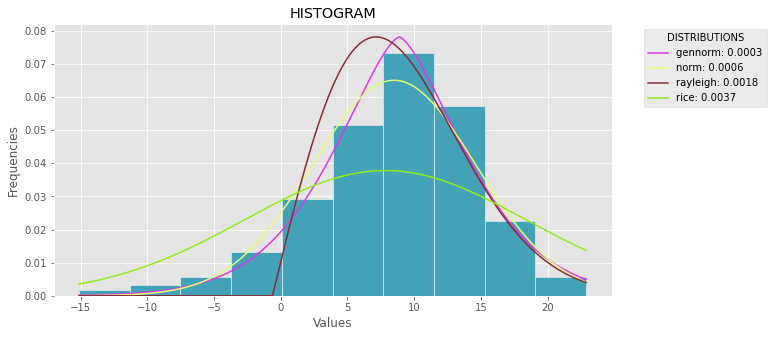

In [17]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import random
import csv



mpl.style.use("ggplot")

"""
DANOE'S FORMULA
https://en.wikipedia.org/wiki/Histogram#Doane's_formula
"""
def danoes_formula(data):
    N = len(data)
    skewness = st.skew(data)
    sigma_g1 = math.sqrt((6*(N-2))/((N+1)*(N+3)))
    num_bins = 1 + math.log(N,2) + math.log(1+abs(skewness)/sigma_g1,2)
    num_bins = round(num_bins)
    return num_bins

def plot_histogram(data, results, n):
    ## n first distribution of the ranking
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}

    ## Histogram of data
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235))
    plt.title('HISTOGRAM')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')

    ## Plot n distributions
    for distribution, result in N_DISTRIBUTIONS.items():
        # print(i, distribution)
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        plt.plot(x_plot, y_plot, label=str(distribution)[32:-34] + ": " + str(sse)[0:6], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))
    
    plt.legend(title='DISTRIBUTIONS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def fit_data(data):
    ## st.frechet_r,st.frechet_l: are disbled in current SciPy version
    ## st.levy_stable: a lot of time of estimation parameters
    ALL_DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm, st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    
    #MY_DISTRIBUTIONS = [st.beta, st.expon, st.norm, st.uniform, st.johnsonsb, st.gennorm, st.gausshyper, st.rayleigh, st.rice]
    MY_DISTRIBUTIONS = [st.norm, st.gennorm, st.rayleigh, st.rice]
    ## Calculae Histogram
    num_bins = danoes_formula(data)
    frequencies, bin_edges = np.histogram(data, num_bins, density=True)
    central_values = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

    results = {}
    for distribution in MY_DISTRIBUTIONS:
        ## Get parameters of distribution
        params = distribution.fit(data)
        
        ## Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        # Add a small constant to the PDF to avoid taking the log of zero
        epsilon = 1e-10
        ## Calculate fitted PDF and error with fit in distribution
        pdf_values = [distribution.pdf(c, loc=loc, scale=scale, *arg) for c in central_values]
        
        ## Calculate SSE (sum of squared estimate of errors)
        sse = np.sum(np.power(frequencies - pdf_values, 2.0))
        
        ## Build results and sort by sse
        results[distribution] = [sse, arg, loc, scale]
        
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results
        
def main():
    ## Import data
    # Read CSV file into array
    with open('array1000_new_Known_Ant_Pos.csv', mode='r') as file:
        reader = csv.reader(file)
        arr = np.array(list(reader), dtype=float)

    # Get first row of array
    data = arr[:,500]
    #data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
    results = fit_data(data)
    plot_histogram(data, results, 5)

if __name__ == "__main__":
    main()

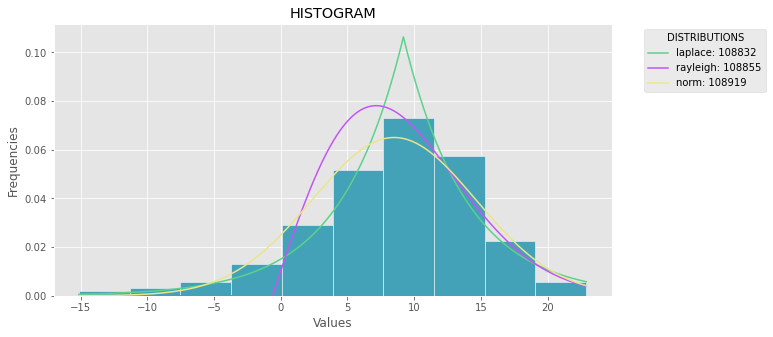

In [16]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import random

def fit_data(data):
    distributions = [st.norm, st.laplace,st.rayleigh]
    
    results = {}
    for distribution in distributions:
        params = distribution.fit(data)
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        
        # Calculate the PDF with a small constant to avoid zero
        epsilon = 1e-10
        pdf_values = distribution.pdf(data, loc=loc, scale=scale, *arg)
        pdf_values = np.maximum(pdf_values, epsilon)
        
        # Calculate SSE (sum of squared estimate of errors)
        sse = np.sum((pdf_values - data)**2)
        
        results[distribution] = [sse, arg, loc, scale]
    
    results = {k: results[k] for k in sorted(results, key=results.get)}
    return results

def plot_histogram(data, results, n):
    plt.figure(figsize=(10, 5))
    plt.hist(data, density=True, ec='white', color=(63/235, 149/235, 170/235))
    plt.title('HISTOGRAM')
    plt.xlabel('Values')
    plt.ylabel('Frequencies')
    
    N_DISTRIBUTIONS = {k: results[k] for k in list(results)[:n]}
    
    for distribution, result in N_DISTRIBUTIONS.items():
        sse = result[0]
        arg = result[1]
        loc = result[2]
        scale = result[3]
        x_plot = np.linspace(min(data), max(data), 1000)
        y_plot = distribution.pdf(x_plot, loc=loc, scale=scale, *arg)
        plt.plot(x_plot, y_plot, label=str(distribution)[32:-34] + ": " + str(sse)[0:6], color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    )
    
    plt.legend(title='DISTRIBUTIONS', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def main():
    ## Import data
    # Read CSV file into array
    with open('array1000_new_Known_Ant_Pos.csv', mode='r') as file:
        reader = csv.reader(file)
        arr = np.array(list(reader), dtype=float)

    # Get first row of array
    data = arr[:,500]
    #data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
    results = fit_data(data)
    plot_histogram(data, results, 5)

if __name__ == "__main__":
    main()